# OCR Project for Debit Cards and National ID Cards

## Importing Libraries

In [1]:
# %pip install requirements.txt

In [2]:
import tensorflow as tf 
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split

import os

In [3]:
utils.set_random_seed(42)

## Constants

In [4]:
from constants import (template_path, trainset_path, num_generating_en, num_generating_ID, 
                        num_processes, batch_size, num_anchors, model_path, model_plot_path)

## Generating Synthesized Dataset

In [5]:
from data_synthesis import generate_multiple_images


templates_type0 = os.listdir(template_path+"/credit")
templates_type1 = os.listdir(template_path+"/national ID")

num_generating_en_each_temp = num_generating_en // len(templates_type0)

templates_type0, templates_type1

(['ayandeh_1.jpg',
  'ayandeh_2.jpg',
  'dey_1.jpg',
  'dey_2.jpg',
  'ghavamin_1.jpg',
  'keshavarzi_1.jpg',
  'keshavarzi_2.jpg',
  'keshavarzi_3.jpg',
  'keshavarzi_4.jpg',
  'keshavarzi_5.jpg',
  'meli_1.jpg',
  'meli_2.jpg',
  'meli_3.jpg',
  'refah_1.jpg',
  'saderat_1.jpg',
  'saderat_2.jpg',
  'saderat_3.jpg',
  'saderat_4.jpg',
  'saderat_5.jpg',
  'saman_1.jpg',
  'sepah_1.jpg',
  'shahr_1.jpg',
  'sina_1.jpg',
  'sina_2.jpg',
  'tejarat_1.jpg',
  'tejarat_2.jpg'],
 ['aa.jpg'])

In [6]:
# for temp_path in templates_type0:
#     generate_multiple_images(
#         temp_path, 
#         num_steps=num_generating_en_each_temp, 
#         gene_type=0, 
#         print_message=f"Generating {num_generating_en_each_temp} new english-numbered, credit-card image with {num_processes} processes"
#     )

In [7]:
# for temp_path in templates_type0:
#     generate_multiple_images(
#         temp_path, 
#         num_steps=num_generating_en_each_temp, 
#         gene_type=0.5, 
#         print_message=f"Generating {num_generating_en_each_temp} new persian-numbered, credit-card image with {num_processes} processes"
#     )

In [8]:
# for temp_path in templates_type1:
#     generate_multiple_images(
#         temp_path, 
#         num_steps=num_generating_ID, 
#         gene_type=1, 
#         print_message=f"Generating {num_generating_ID} new national-ID image with {num_processes} processes"
#     )

### Showing randomly chosen Generated Images

In [9]:
from utilities import show_annotated_img


trainset_images = os.listdir(os.path.join(trainset_path, "images"))
trainset_annotations = os.listdir(os.path.join(trainset_path, "annotations"))

len(trainset_images), len(trainset_annotations)

(199994, 199994)

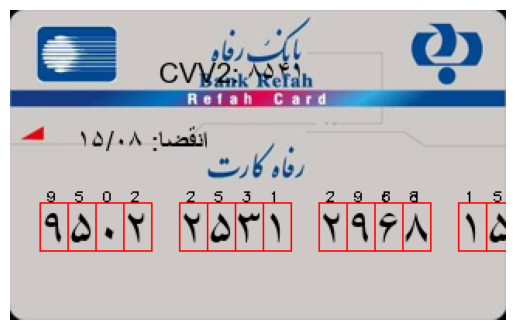

In [10]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[1000]), os.path.join(trainset_path, "annotations", trainset_annotations[1000]))

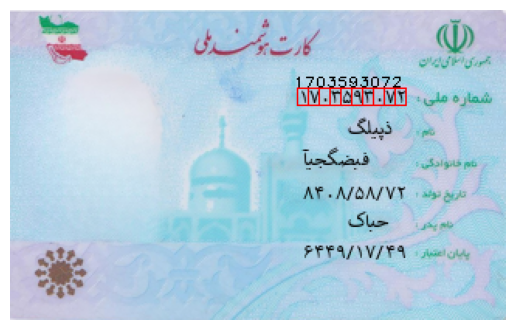

In [11]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[100_000]), os.path.join(trainset_path, "annotations", trainset_annotations[100_000]))

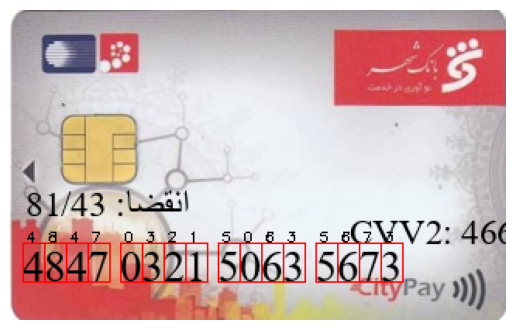

In [12]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[150_001]), os.path.join(trainset_path, "annotations", trainset_annotations[150_001]))

## Preparing the Dataset

In [13]:
x_train, x_val, y_train, y_val = train_test_split(trainset_images, trainset_annotations, test_size=0.15, shuffle=True, random_state=42)
len(x_train), len(x_val)

(169994, 30000)

In [14]:
from data_preparation import create_annotation_lists


train_confs, train_bboxes, train_classes, train_card_types, train_infos = create_annotation_lists(y_train)
val_confs, val_bboxes, val_classes, val_card_types, val_infos = create_annotation_lists(y_val)

Creating a pool of 12 processes for 169994 files.
Closed the pool. Saving the results ...

Creating a pool of 12 processes for 30000 files.
Closed the pool. Saving the results ...



In [15]:
def preprocess_img_annot(img_path, confs, classes_list, bboxes, card_type, info):   
    x = tf.io.read_file(trainset_path+"/images/"+img_path)
    x = tf.image.decode_image(x)

    cvv2, exp_date = info[0], info[1]

    y = {
        **{f"confs_anchor_{i}": confs[..., i, None] for i in range(num_anchors)}, 
        **{f"bboxes_anchor_{i}": bboxes[i] for i in range(len(bboxes))}, 
        **{f"classes_anchor_{i}": classes_list[i] for i in range(len(classes_list))}, 
        "card_type": card_type, 
        # "cvv2": tf.cast(cvv2, dtype=tf.float32)/1e4, 
        # "exp_date": tf.cast(exp_date, dtype=tf.float32)/1e8,
    }
    
    return x, y

In [16]:
trainset = tf.data.Dataset.from_tensor_slices((x_train, train_confs, train_classes, train_bboxes, train_card_types, train_infos))
trainset = trainset.map(preprocess_img_annot, num_parallel_calls=5)
trainset = trainset.shuffle(1_000).batch(batch_size).prefetch(5)

valset = tf.data.Dataset.from_tensor_slices((x_val, val_confs, val_classes, val_bboxes, val_card_types, val_infos))
valset = valset.map(preprocess_img_annot, num_parallel_calls=5)
valset = valset.batch(batch_size).prefetch(5)

## Creating the Model

In [19]:
from model_creation import create_sliding_window_ocr_model


model = create_sliding_window_ocr_model()

model.summary()

Model: "sliding_window_ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation_layer (Seque  (None, 200, 320, 3)  0          ['image[0][0]']                  
 ntial)                                                                                           
                                                                                                  
 xception_preprocess (Lambda)   (None, 200, 320, 3)  0           ['data_augmentation_layer[0][0]']
                                                                           

In [20]:
utils.plot_model(
    model,
    to_file=model_plot_path,
    show_shapes=True,
    show_layer_names=True,
    dpi=1000,
)

## Training the Model

In [21]:
from callback_creation import callback_list


history = model.fit(
    trainset,
    epochs=100,
    validation_data=valset,
    callbacks=callback_list,
).history

Epoch 13/100
2657/2657 [==============================] - 3815s 1s/step - loss: 0.7314 - bboxes_anchor_0_loss: 8.3369e-04 - bboxes_anchor_1_loss: 7.2468e-04 - bboxes_anchor_2_loss: 7.4904e-04 - bboxes_anchor_3_loss: 8.2150e-04 - bboxes_anchor_4_loss: 9.3797e-04 - bboxes_anchor_5_loss: 0.0011 - bboxes_anchor_6_loss: 0.0012 - bboxes_anchor_7_loss: 0.0014 - bboxes_anchor_8_loss: 0.0017 - bboxes_anchor_9_loss: 0.0022 - card_type_loss: 6.9397e-05 - classes_anchor_0_loss: 0.0429 - classes_anchor_1_loss: 0.0460 - classes_anchor_2_loss: 0.0421 - classes_anchor_3_loss: 0.0431 - classes_anchor_4_loss: 0.0566 - classes_anchor_5_loss: 0.0437 - classes_anchor_6_loss: 0.0475 - classes_anchor_7_loss: 0.0500 - classes_anchor_8_loss: 0.0468 - classes_anchor_9_loss: 0.0654 - confs_anchor_0_loss: 0.0233 - confs_anchor_1_loss: 0.0218 - confs_anchor_2_loss: 0.0221 - confs_anchor_3_loss: 0.0225 - confs_anchor_4_loss: 0.0232 - confs_anchor_5_loss: 0.0247 - confs_anchor_6_loss: 0.0239 - confs_anchor_7_loss: 0

KeyboardInterrupt: 

## Plotting the Training Metrics

In [ ]:
from history_plotting import plot_history


plot_history(history)

## Predicting by the Model

In [22]:
from tensorflow.keras.models import load_model

from utilities import predict_and_show
from ocr_model import OCRModel


model = load_model(model_path, custom_objects={"OCRModel": OCRModel})

1/1 [==============================] - 2s 2s/step
Confidence Scores: [0.62, 0.75, 0.98, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [0, 0, 0, 5, 6, 8, 1, 9, 2, 5, 3, 4, 0, 7, 4, 6, 6]
Found Objects #: 17

Card Type: 0.0
CVV2: 0
Expiration Date: 0


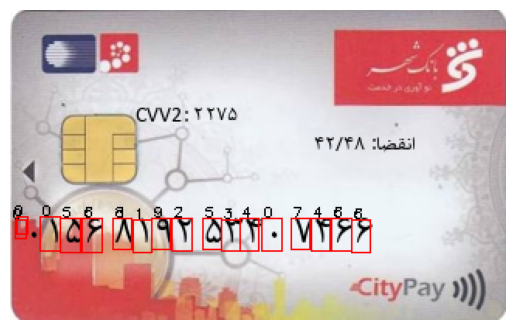

In [23]:
predict_and_show(model, "./dataset/trainset/images/"+x_train[10])

1/1 [==============================] - 0s 47ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [4, 2, 2, 7, 8, 0, 6, 6, 9, 6]
Found Objects #: 10

Card Type: 1.0
CVV2: 0
Expiration Date: 0


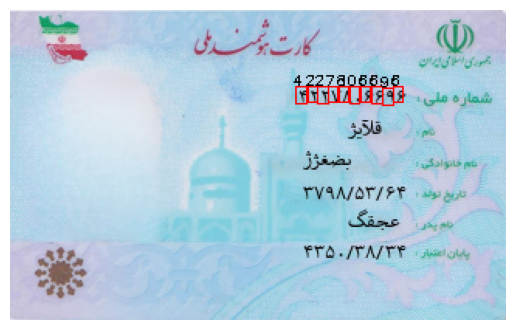

In [24]:
predict_and_show(model, "./dataset/trainset/images/"+x_train[0])

1/1 [==============================] - 0s 34ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [9, 4, 3, 3, 8, 1, 0, 0, 0, 9, 4, 4, 5]
Found Objects #: 13

Card Type: 0.0
CVV2: 0
Expiration Date: 0


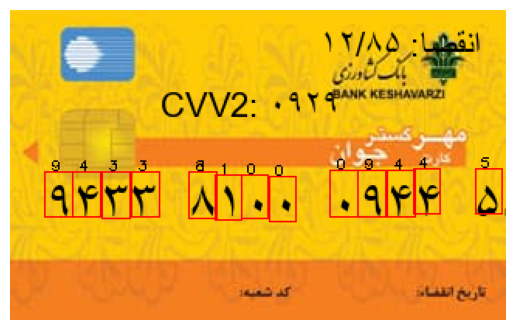

In [25]:
predict_and_show(model, "./dataset/trainset/images/"+x_val[150])

1/1 [==============================] - 0s 33ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [4, 2, 4, 5, 8, 6, 9, 8, 3, 1]
Found Objects #: 10

Card Type: 1.0
CVV2: 0
Expiration Date: 0


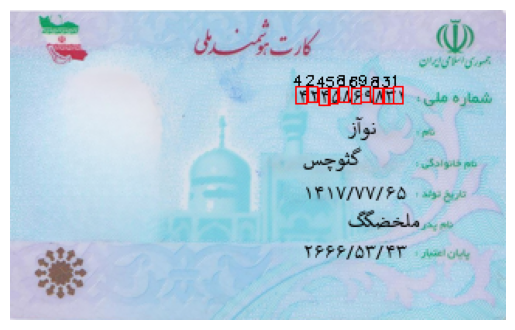

In [26]:
predict_and_show(model, "./dataset/trainset/images/"+x_val[2])

1/1 [==============================] - 0s 33ms/step
Confidence Scores: [0.56, 0.78, 0.67, 0.82, 0.58, 0.78, 0.86, 0.98, 0.63, 0.99, 0.93, 0.72, 0.91, 0.54]
Found Classes: [0, 5, 0, 1, 0, 0, 8, 0, 0, 0, 0, 1, 8, 2]
Found Objects #: 14

Card Type: 0.0
CVV2: 0
Expiration Date: 0


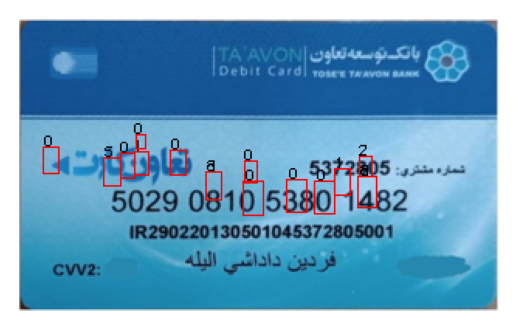

In [27]:
predict_and_show(model, "./dataset/testset/0.png")